In [553]:
!pip install FDApy

In [554]:
import matplotlib.pyplot as plt
import numpy as np

from FDApy.representation import DenseArgvals, DenseValues
from FDApy.simulation import KarhunenLoeve
from FDApy.preprocessing import UFPCA
from FDApy.visualization import plot
from FDApy import DenseFunctionalData

# Введение

В данном ноутбуке был применён FPCA к игрушечной проблеме для полиномиальных функций с шумом на конечной сетке. Цель была в том, чтобы предсказать порядок полиномов.

Нами была выбрана библиотека FDApy, т.к. она более активно поддерживается, чем scikit-fda

Структура ноутбука:

<ol>
  <li>Окрестность нуля:
    <ol>
      <li>Малое число компонент,</li>
      <li>Точное число компонент,</li>
      <li>Адаптивное число компонент.</li>
    </ol>
  </li>
  <li>Не окрестность нуля:
    <ol>
      <li>Малое число компонент,</li>
      <li>Точное число компонент,</li>
      <li>Адаптивное число компонент.</li>
    </ol>
  </li>
  <li>Сильный шум:
    <ol>
      <li>Малое число компонент,</li>
      <li>Точное число компонент,</li>
      <li>Адаптивное число компонент.</li>
    </ol>
  </li>
  <li>Выводы</li>
</ol>

Для разделов 2 и 3 будет опущена визуализация очков, т.к. она не несёт принципиально важной визуальной информации

# Окрестность нуля

In [555]:
polynom_power = 8 # Степень полинома
function_count = 60 # Число "наблюдений"-функций

margin = 3

# Сетка значений [-margin, margin], в которых считаются функции
# В данном примере - плотная
argvals = np.linspace(-margin, margin, num=100)

# Массив наблюдений
X = []
X_true = []
np.random.seed(3)

for i in range(function_count):
  # Получаем коэффициенты для полинома из
  # нормального распределения и строим np полином
  coefs = np.random.randn(polynom_power) * margin
  poly = np.poly1d(coefs, r=True)
  # Получаем шум в 100 точках, чтобы добавить
  # его к истинным наблюдениям
  noise = np.random.randn(100) * 1000
  # В X идут зашумлённые наблюдения
  X.append(poly(argvals) + noise)
  # В X_true чистые
  X_true.append(poly(argvals))

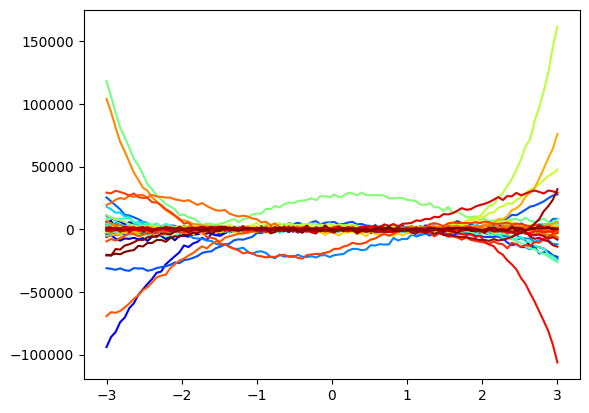

In [556]:
# Передаём данные в конструктор FunctionalData библиотеки
# и выполняем визуализацию зашумлённых данных
data = DenseFunctionalData(
    argvals=DenseArgvals({"input_dim_0": argvals}), values=DenseValues(X)
)

data_true = DenseFunctionalData(
    argvals=DenseArgvals({"input_dim_0": argvals}), values=DenseValues(X_true)
)

_ = plot(data)

## Разложение с недостаточным числом компонент

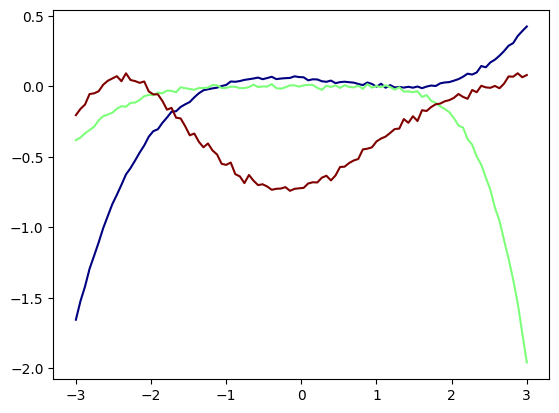

In [557]:
# Сначала мы выполняем одномерный FPCA, используя разложение оператора ковариации
# с малым числом компонент
ufpca_cov_3_comp = UFPCA(n_components=3, method="covariance")
ufpca_cov_3_comp.fit(data)

# Строим график собственных функций, используя полученное выше разложение
_ = plot(ufpca_cov_3_comp.eigenfunctions)
plt.show()

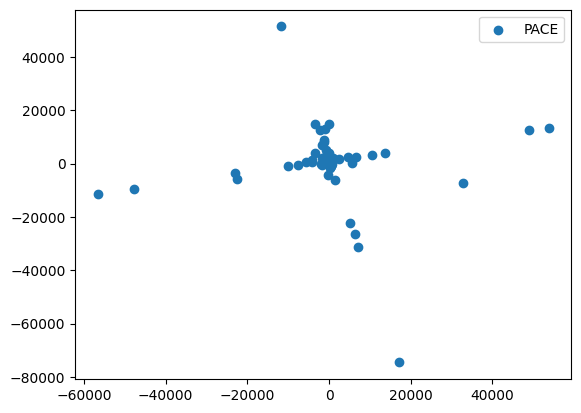

In [558]:
# Считаем оценки нашего разложения с помощью метода PACE,
# который мы описывали в лит. обзоре
scores_pace_3_comp = ufpca_cov_3_comp.transform(data, method="PACE")

# Визуализируем очки наших функций
plt.scatter(scores_pace_3_comp[:, 0], scores_pace_3_comp[:, 1], label="PACE")
plt.legend()
plt.show()

### Наблюдения

Легко видеть, что числа компонент 3 сильно не хватает, чтобы выучить форму функций. Базис не достаточно богатый, чтобы из него восстановить исходные наблюдения

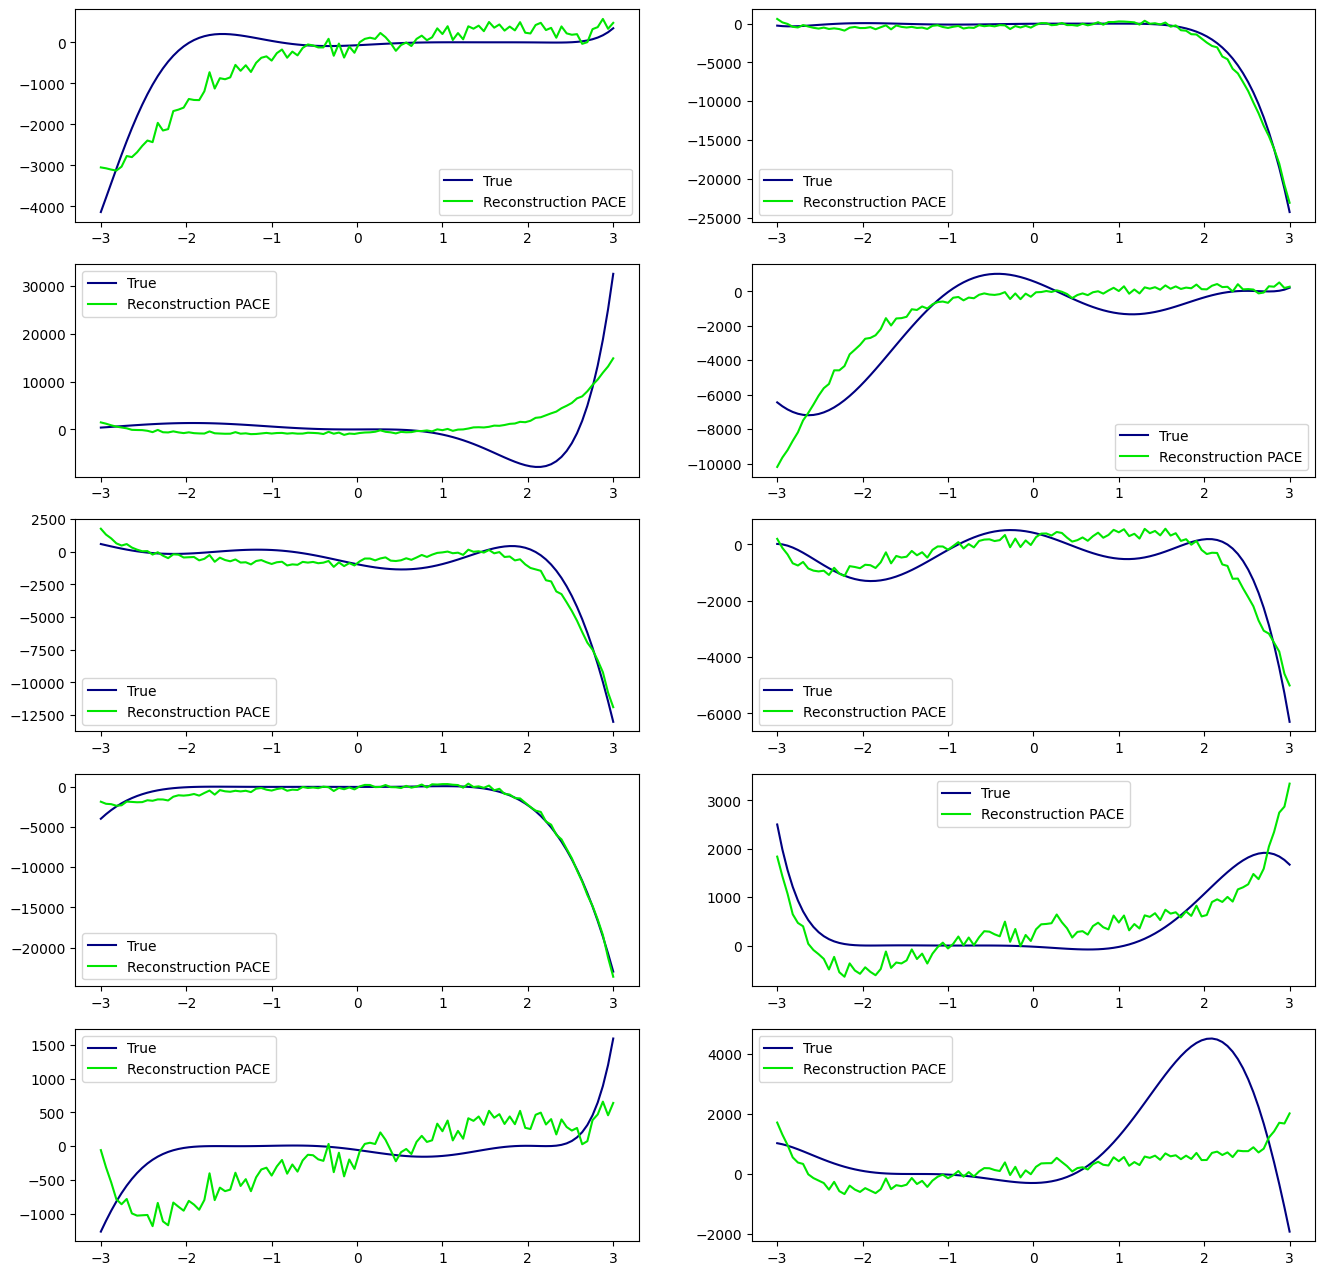

In [559]:
# Выполняем обратно преобразование очков в данные из
# уже имеющегося разложения
data_recons_pace = ufpca_cov_3_comp.inverse_transform(scores_pace_3_comp)

# Выбираем цвет, которым покрасим график восстановленных функций
colors_pace = np.array([[0, 0.9, 0, 1]])

np.random.seed(3)

# Строим сетку графиков и визуализируем 10 случайных наблюдений
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(16, 16))
for idx_plot, idx in enumerate(np.random.choice(function_count, 10)):
    temp_ax = axes.flatten()[idx_plot]
    # Визуализируем истинные, не зашумлённые наблюдения
    temp_ax = plot(data_true[idx], ax=temp_ax, label="True")
    # Визуализируем восстановленные из PACE очков функции
    plot(
        data_recons_pace[idx],
        colors=colors_pace,
        ax=temp_ax,
        label="Reconstruction PACE",
    )
    temp_ax.legend()
plt.show()

## Разложение с точным числом компонент

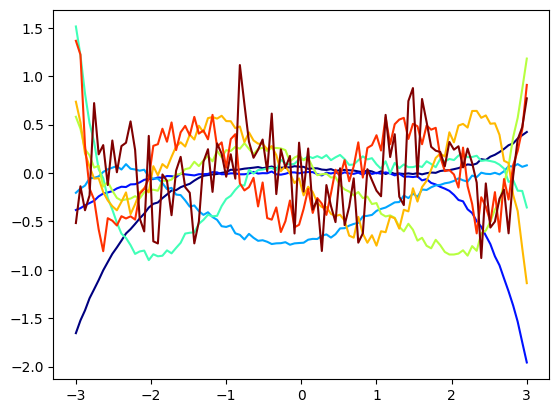

In [560]:
# Теперь мы выполняем одномерный FPCA, используя разложение оператора ковариации
# с точным числом компонент
ufpca_cov_p_comp = UFPCA(n_components=polynom_power, method="covariance")
ufpca_cov_p_comp.fit(data)

# Строим график собственных функций, используя полученное выше разложение
_ = plot(ufpca_cov_p_comp.eigenfunctions)
plt.show()

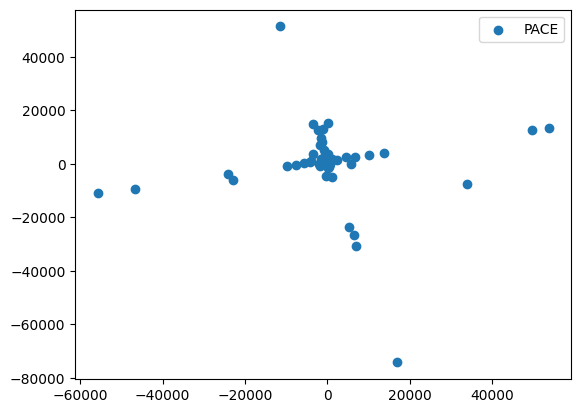

In [561]:
# Считаем оценки нашего разложения с помощью метода PACE,
# который мы описывали в лит. обзоре
scores_pace_p_comp = ufpca_cov_p_comp.transform(data, method="PACE")

# Визуализируем очки наших функций
plt.scatter(scores_pace_p_comp[:, 0], scores_pace_p_comp[:, 1], label="PACE")
plt.legend()
plt.show()

### Наблюдения

Сравнивая с предыдущим примером, можно заметить, что попадание в форму наблюдений-функций стало значительно лучше. Это указывает на то, что базис достаточно богат, чтобы функции могли быть восстановлены.

Тем не менее, присутствующий в наблюдениях шум не позволяет точно восстановить зависимость.

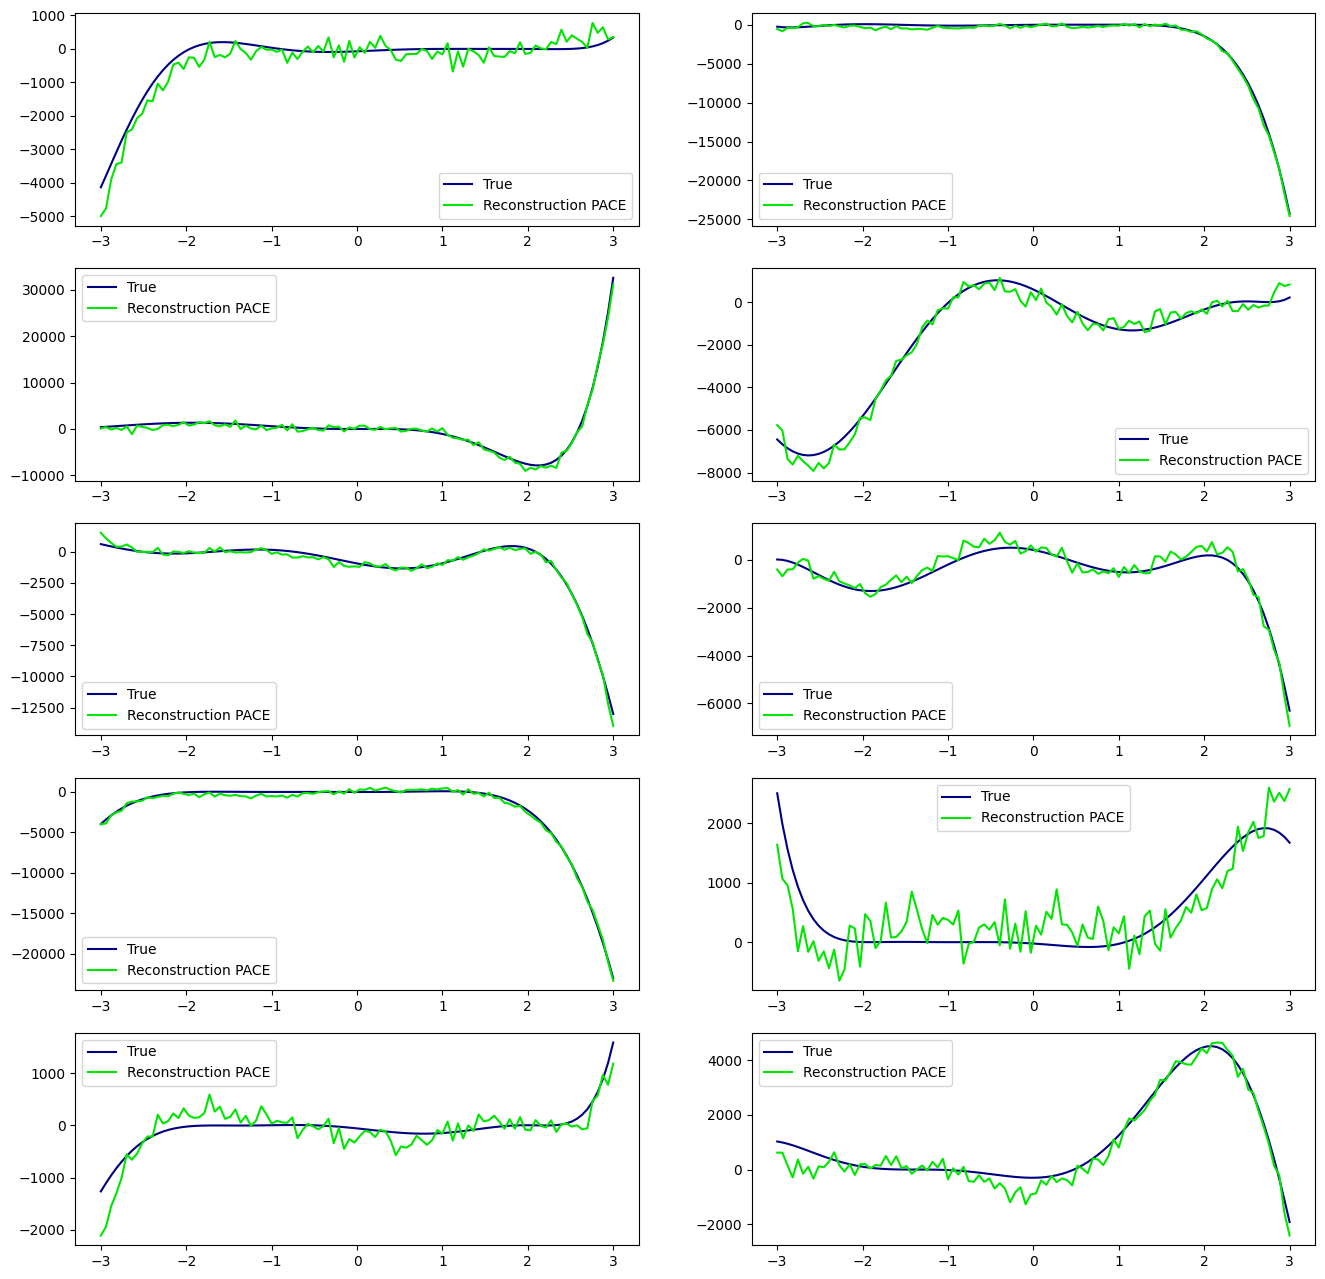

In [562]:
# Выполняем обратно преобразование очков в данные из
# уже имеющегося разложения
data_recons_pace = ufpca_cov_p_comp.inverse_transform(scores_pace_p_comp)

# Выбираем цвет, которым покрасим график восстановленных функций
colors_pace = np.array([[0, 0.9, 0, 1]])

np.random.seed(3)

# Строим сетку графиков и визуализируем 10 случайных наблюдений
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(16, 16))
for idx_plot, idx in enumerate(np.random.choice(function_count, 10)):
    temp_ax = axes.flatten()[idx_plot]
    # Визуализируем истинные, не зашумлённые наблюдения
    temp_ax = plot(data_true[idx], ax=temp_ax, label="True")
    # Визуализируем восстановленные из PACE очков функции
    plot(
        data_recons_pace[idx],
        colors=colors_pace,
        ax=temp_ax,
        label="Reconstruction PACE",
    )
    temp_ax.legend()
plt.show()

## Разложение с учётом объяснённой дисперсии

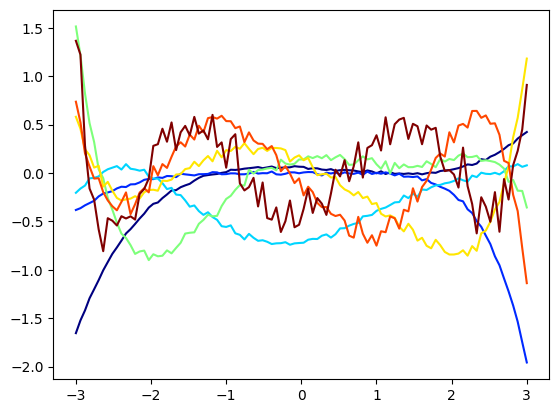

In [563]:
# Теперь мы выполняем одномерный FPCA, используя разложение оператора ковариации
# с адаптивным числом компонент, которое объясняет 99% дисперсии
ufpca_cov_a_comp = UFPCA(n_components=0.99, method="covariance")
ufpca_cov_a_comp.fit(data)

# Строим график собственных функций, используя полученное выше разложение
_ = plot(ufpca_cov_a_comp.eigenfunctions)
plt.show()

Адаптивный выбор числа компонент предлагает 7 функций в базисе. Это довольно близко к реальному числу компонент - 8

In [564]:
ufpca_cov_a_comp.eigenfunctions

Functional data object with 7 observations on a 1-dimensional support.

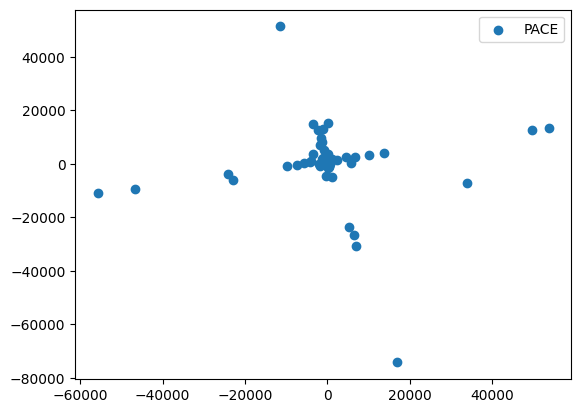

In [565]:
# Считаем оценки нашего разложения с помощью метода PACE,
# который мы описывали в лит. обзоре
scores_pace_a_comp = ufpca_cov_a_comp.transform(data, method="PACE")

# Визуализируем очки наших функций
plt.scatter(scores_pace_a_comp[:, 0], scores_pace_a_comp[:, 1], label="PACE")
plt.legend()
plt.show()

### Наблюдения

Метод с адаптивным выбором числа компонент показал себя лучше, чем базовый случай с 3 компонентами, но хуже, чем случай с точным соответствием. Вероятно, это связано с тем, что в окрестности нуля полиномы высокой степени неплохо приближаются более низко-степенными функциями.

Тем не менее, визуально видны некоторые несоответствия.

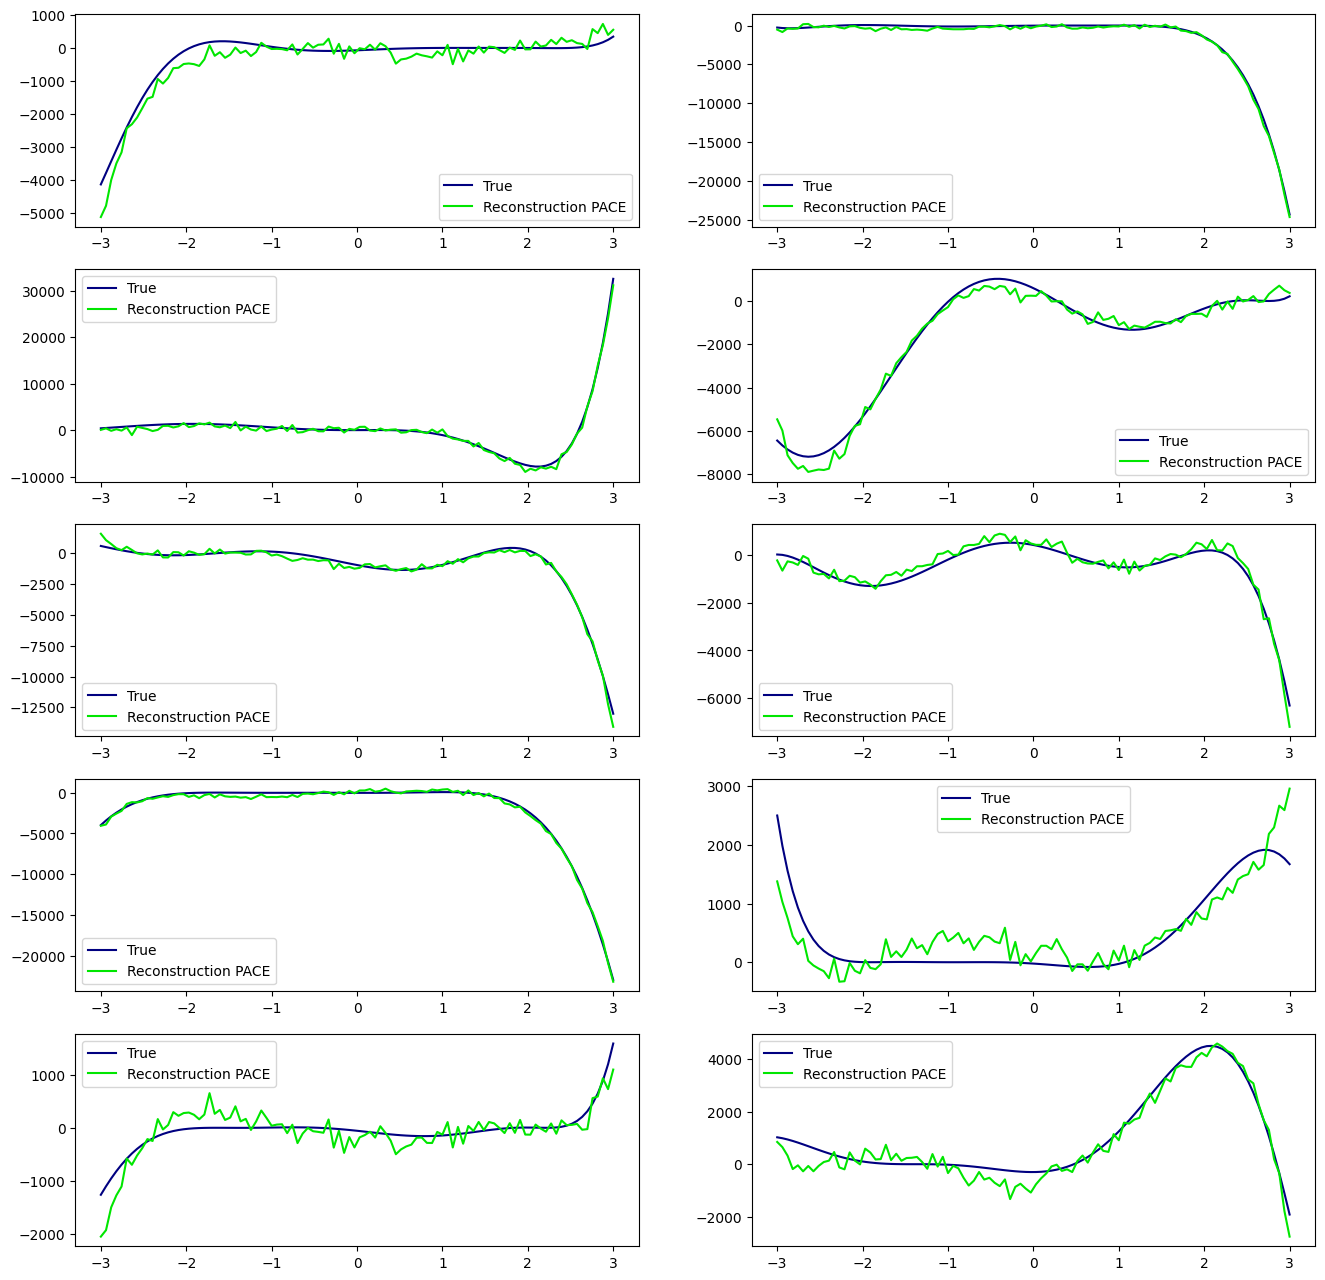

In [566]:
# Выполняем обратно преобразование очков в данные из
# уже имеющегося разложения
data_recons_pace = ufpca_cov_a_comp.inverse_transform(scores_pace_a_comp)

# Выбираем цвет, которым покрасим график восстановленных функций
colors_pace = np.array([[0, 0.9, 0, 1]])

np.random.seed(3)

# Строим сетку графиков и визуализируем 10 случайных наблюдений
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(16, 16))
for idx_plot, idx in enumerate(np.random.choice(function_count, 10)):
    temp_ax = axes.flatten()[idx_plot]
    # Визуализируем истинные, не зашумлённые наблюдения
    temp_ax = plot(data_true[idx], ax=temp_ax, label="True")
    # Визуализируем восстановленные из PACE очков функции
    plot(
        data_recons_pace[idx],
        colors=colors_pace,
        ax=temp_ax,
        label="Reconstruction PACE",
    )
    temp_ax.legend()
plt.show()

# Не окрестность нуля

In [567]:
polynom_power = 8 # Степень полинома
function_count = 60 # Число "наблюдений"-функций

margin = 1

# Сетка значений [5 - margin, 5 + margin], в которых считаются функции
# В данном примере - плотная
argvals = np.linspace(3 - margin, 3 + margin, num=100)

# Массив наблюдений
X = []
X_true = []
np.random.seed(3)

for i in range(function_count):
  # Получаем коэффициенты для полинома из
  # нормального распределения и строим np полином
  coefs = np.random.randn(polynom_power) * margin
  poly = np.poly1d(coefs, r=True)
  # Получаем шум в 100 точках, чтобы добавить
  # его к истинным наблюдениям
  noise = np.random.randn(100) * 1000
  # В X идут зашумлённые наблюдения
  X.append(poly(argvals) + noise)
  # В X_true чистые
  X_true.append(poly(argvals))

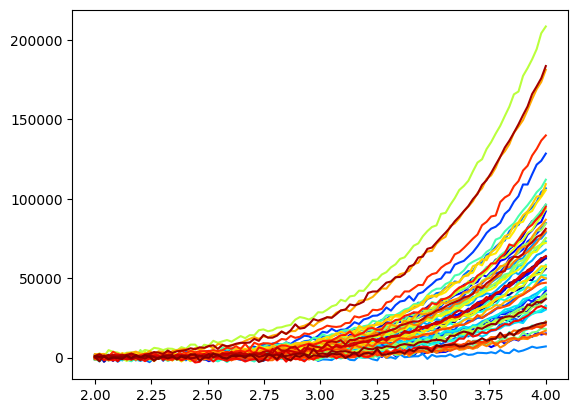

In [568]:
# Передаём данные в конструктор FunctionalData библиотеки
# и выполняем визуализацию зашумлённых данных
data = DenseFunctionalData(
    argvals=DenseArgvals({"input_dim_0": argvals}), values=DenseValues(X)
)

data_true = DenseFunctionalData(
    argvals=DenseArgvals({"input_dim_0": argvals}), values=DenseValues(X_true)
)

_ = plot(data)

## Разложение с недостаточным числом компонент

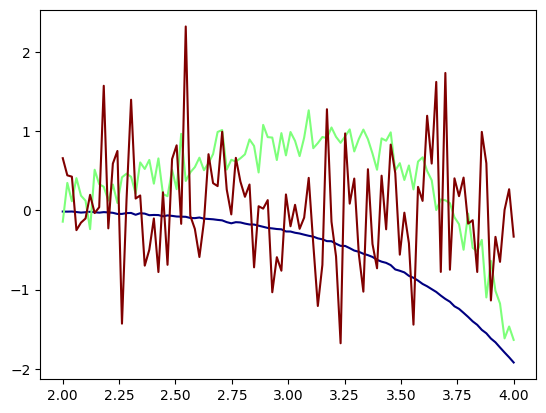

In [569]:
# Сначала мы выполняем одномерный FPCA, используя разложение оператора ковариации
# с малым числом компонент
ufpca_cov_3_comp = UFPCA(n_components=3, method="covariance")
ufpca_cov_3_comp.fit(data)

# Строим график собственных функций, используя полученное выше разложение
_ = plot(ufpca_cov_3_comp.eigenfunctions)
plt.show()

In [570]:
scores_pace_3_comp = ufpca_cov_3_comp.transform(data, method="PACE")

### Наблюдения

В случае, когда мы отходим достаточно далеко от зоны концентрации корней полиномов, его часть в наибольшей степенью доминирует остальные и даже малое число компонент достаточно для объяснения наблюдений.

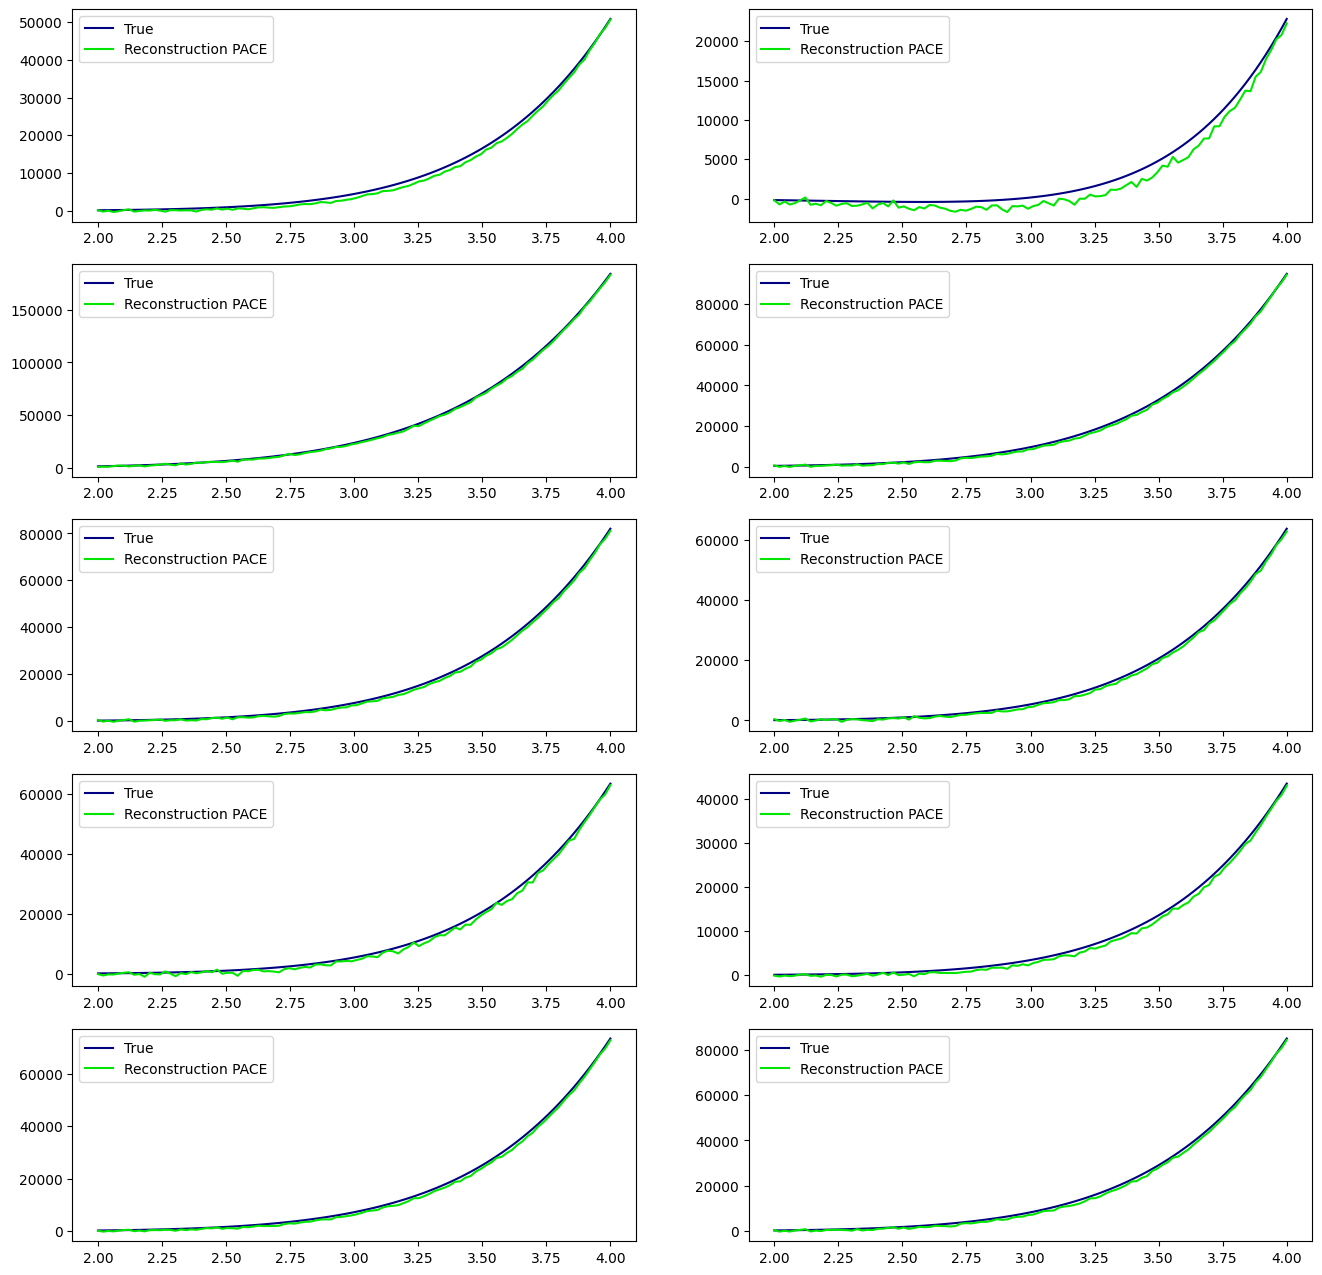

In [571]:
# Выполняем обратно преобразование очков в данные из
# уже имеющегося разложения
data_recons_pace = ufpca_cov_3_comp.inverse_transform(scores_pace_3_comp)

# Выбираем цвет, которым покрасим график восстановленных функций
colors_pace = np.array([[0, 0.9, 0, 1]])

np.random.seed(3)

# Строим сетку графиков и визуализируем 10 случайных наблюдений
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(16, 16))
for idx_plot, idx in enumerate(np.random.choice(function_count, 10)):
    temp_ax = axes.flatten()[idx_plot]
    # Визуализируем истинные, не зашумлённые наблюдения
    temp_ax = plot(data_true[idx], ax=temp_ax, label="True")
    # Визуализируем восстановленные из PACE очков функции
    plot(
        data_recons_pace[idx],
        colors=colors_pace,
        ax=temp_ax,
        label="Reconstruction PACE",
    )
    temp_ax.legend()
plt.show()

## Разложение с точным числом компонент

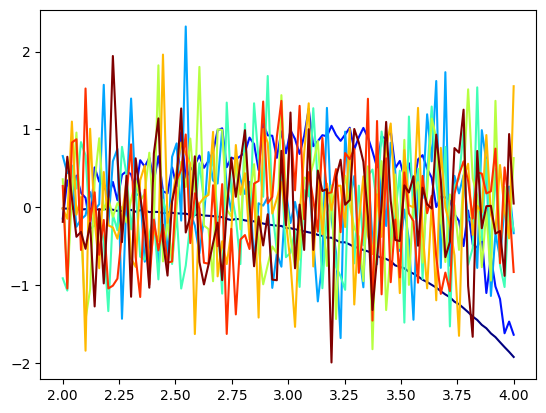

In [572]:
# Теперь мы выполняем одномерный FPCA, используя разложение оператора ковариации
# с точным числом компонент
ufpca_cov_p_comp = UFPCA(n_components=polynom_power, method="covariance")
ufpca_cov_p_comp.fit(data)

# Строим график собственных функций, используя полученное выше разложение
_ = plot(ufpca_cov_p_comp.eigenfunctions)
plt.show()

In [573]:
# Считаем оценки нашего разложения с помощью метода PACE,
# который мы описывали в лит. обзоре
scores_pace_p_comp = ufpca_cov_p_comp.transform(data, method="PACE")

### Наблюдения

Как уже было указано выше, когда почти все компоненты полинома доминируются наибольшей, добавление дополнительных компонент в разложение не улучшит и без того неплохое поведение. Графики практически неотличимы визуально, а добавленные компоненты, как видно из графика над подсчётом очков, скорее шумовые.

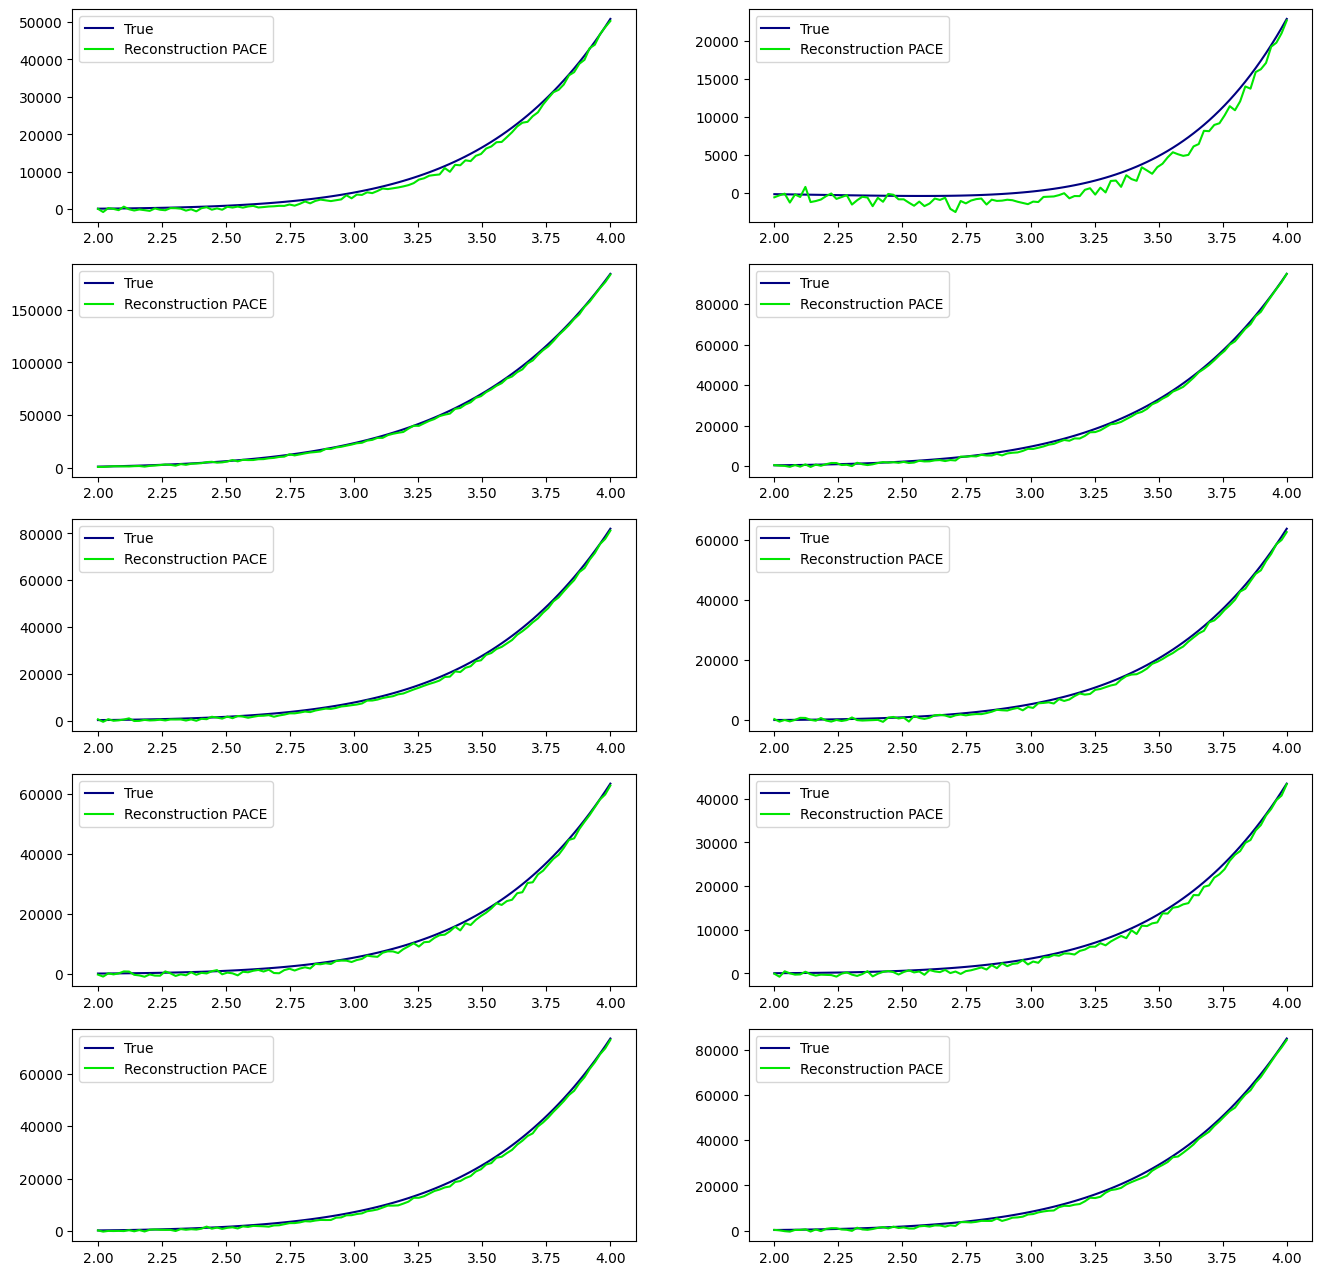

In [574]:
# Выполняем обратно преобразование очков в данные из
# уже имеющегося разложения
data_recons_pace = ufpca_cov_p_comp.inverse_transform(scores_pace_p_comp)

# Выбираем цвет, которым покрасим график восстановленных функций
colors_pace = np.array([[0, 0.9, 0, 1]])

np.random.seed(3)

# Строим сетку графиков и визуализируем 10 случайных наблюдений
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(16, 16))
for idx_plot, idx in enumerate(np.random.choice(function_count, 10)):
    temp_ax = axes.flatten()[idx_plot]
    # Визуализируем истинные, не зашумлённые наблюдения
    temp_ax = plot(data_true[idx], ax=temp_ax, label="True")
    # Визуализируем восстановленные из PACE очков функции
    plot(
        data_recons_pace[idx],
        colors=colors_pace,
        ax=temp_ax,
        label="Reconstruction PACE",
    )
    temp_ax.legend()
plt.show()

## Разложение с учётом объяснённой дисперсии

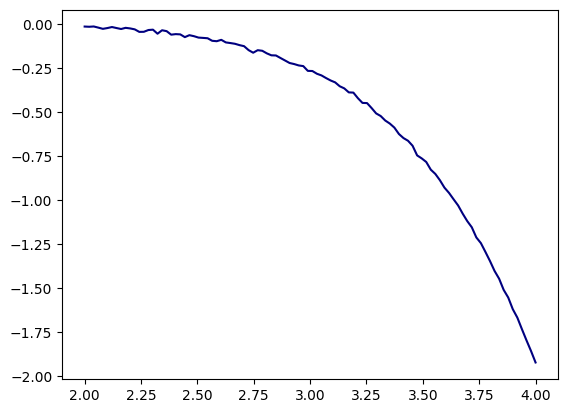

In [575]:
# Теперь мы выполняем одномерный FPCA, используя разложение оператора ковариации
# с адаптивным числом компонент, которое объясняет 99% дисперсии
ufpca_cov_a_comp = UFPCA(n_components=0.99, method="covariance")
ufpca_cov_a_comp.fit(data)

# Строим график собственных функций, используя полученное выше разложение
_ = plot(ufpca_cov_a_comp.eigenfunctions)
plt.show()

Адаптивный выбор числа компонент предлагает 1 функцию в базисе. Это крайне далеко от реального числа 8

In [576]:
ufpca_cov_a_comp.eigenfunctions

Functional data object with 1 observations on a 1-dimensional support.

In [577]:
# Считаем оценки нашего разложения с помощью метода PACE,
# который мы описывали в лит. обзоре
scores_pace_a_comp = ufpca_cov_a_comp.transform(data, method="PACE")

### Наблюдения

Метод с адаптивным выбором числа компонент наглядно показывает, что для объяснения 99% дисперсии в данном случае достаточно одной единственной компоненты. Графики хорошие и даже лучше, чем для точного числа компонент, т.к. содержат меньше шума.

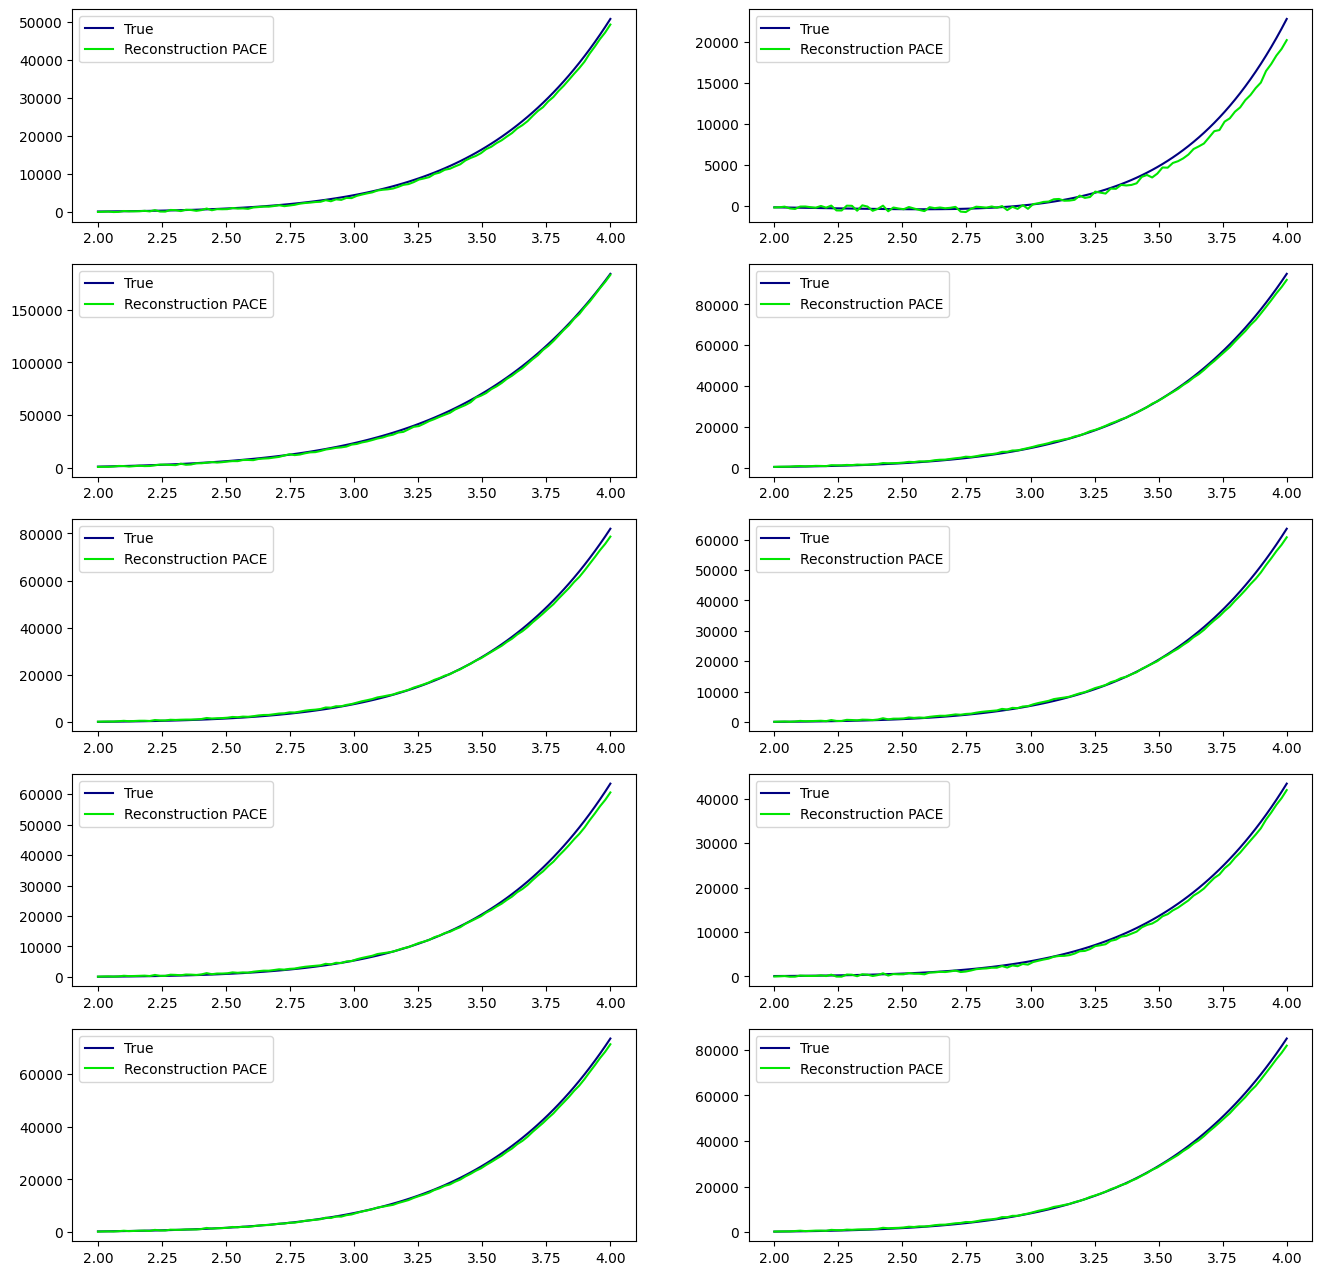

In [578]:
# Выполняем обратно преобразование очков в данные из
# уже имеющегося разложения
data_recons_pace = ufpca_cov_a_comp.inverse_transform(scores_pace_a_comp)

# Выбираем цвет, которым покрасим график восстановленных функций
colors_pace = np.array([[0, 0.9, 0, 1]])

np.random.seed(3)

# Строим сетку графиков и визуализируем 10 случайных наблюдений
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(16, 16))
for idx_plot, idx in enumerate(np.random.choice(function_count, 10)):
    temp_ax = axes.flatten()[idx_plot]
    # Визуализируем истинные, не зашумлённые наблюдения
    temp_ax = plot(data_true[idx], ax=temp_ax, label="True")
    # Визуализируем восстановленные из PACE очков функции
    plot(
        data_recons_pace[idx],
        colors=colors_pace,
        ax=temp_ax,
        label="Reconstruction PACE",
    )
    temp_ax.legend()
plt.show()

# Сильный шум

In [579]:
polynom_power = 8 # Степень полинома
function_count = 60 # Число "наблюдений"-функций

margin = 1

# Сетка значений [-margin, margin], в которых считаются функции
# В данном примере - плотная
argvals = np.linspace(-margin, margin, num=100)

# Массив наблюдений
X = []
X_true = []
np.random.seed(3)

for i in range(function_count):
  # Получаем коэффициенты для полинома из
  # нормального распределения и строим np полином
  coefs = np.random.randn(polynom_power) * margin
  poly = np.poly1d(coefs, r=True)
  # Получаем шум в 100 точках, чтобы добавить
  # его к истинным наблюдениям
  noise = np.random.randn(100) * 1
  # В X идут зашумлённые наблюдения
  X.append(poly(argvals) + noise)
  # В X_true чистые
  X_true.append(poly(argvals))

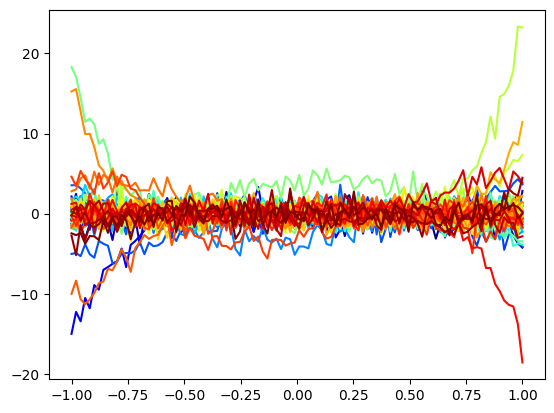

In [580]:
# Передаём данные в конструктор FunctionalData библиотеки
# и выполняем визуализацию зашумлённых данных
data = DenseFunctionalData(
    argvals=DenseArgvals({"input_dim_0": argvals}), values=DenseValues(X)
)

data_true = DenseFunctionalData(
    argvals=DenseArgvals({"input_dim_0": argvals}), values=DenseValues(X_true)
)

_ = plot(data)

## Разложение с недостаточным числом компонент

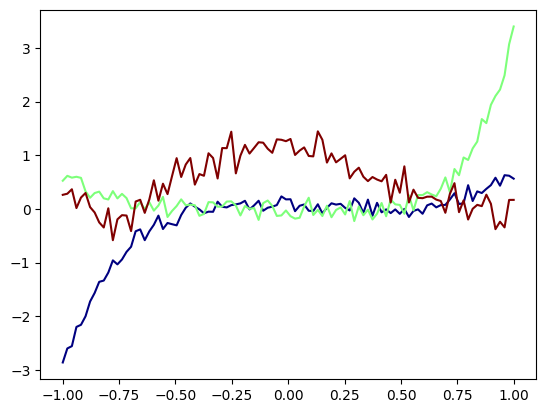

In [581]:
# Сначала мы выполняем одномерный FPCA, используя разложение оператора ковариации
# с малым числом компонент
ufpca_cov_3_comp = UFPCA(n_components=3, method="covariance")
ufpca_cov_3_comp.fit(data)

# Строим график собственных функций, используя полученное выше разложение
_ = plot(ufpca_cov_3_comp.eigenfunctions)
plt.show()

In [582]:
scores_pace_3_comp = ufpca_cov_3_comp.transform(data, method="PACE")

### Наблюдения

В случае, когда шума в данных много, недостаточное число компонент справляется примерно так же плохо, как и при меньшем числе шума. Оно не улавливает форму поведения наблюдений и не может восстановить его достаточно точно.

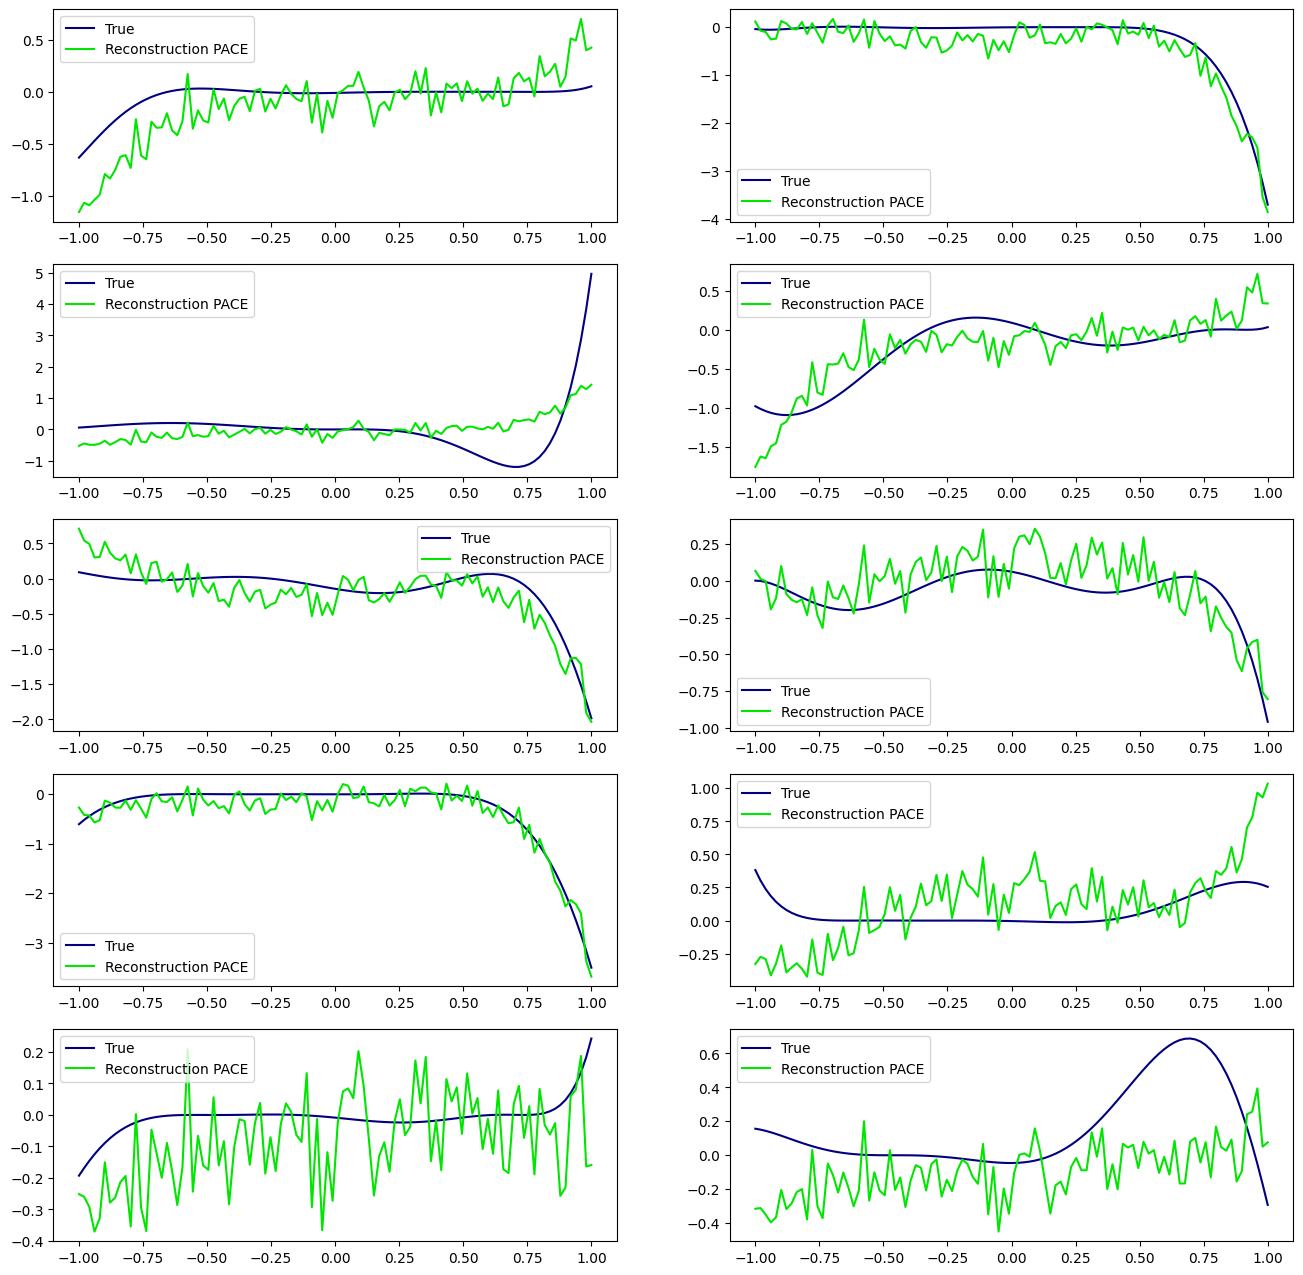

In [583]:
# Выполняем обратно преобразование очков в данные из
# уже имеющегося разложения
data_recons_pace = ufpca_cov_3_comp.inverse_transform(scores_pace_3_comp)

# Выбираем цвет, которым покрасим график восстановленных функций
colors_pace = np.array([[0, 0.9, 0, 1]])

np.random.seed(3)

# Строим сетку графиков и визуализируем 10 случайных наблюдений
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(16, 16))
for idx_plot, idx in enumerate(np.random.choice(function_count, 10)):
    temp_ax = axes.flatten()[idx_plot]
    # Визуализируем истинные, не зашумлённые наблюдения
    temp_ax = plot(data_true[idx], ax=temp_ax, label="True")
    # Визуализируем восстановленные из PACE очков функции
    plot(
        data_recons_pace[idx],
        colors=colors_pace,
        ax=temp_ax,
        label="Reconstruction PACE",
    )
    temp_ax.legend()
plt.show()

## Разложение с точным числом компонент

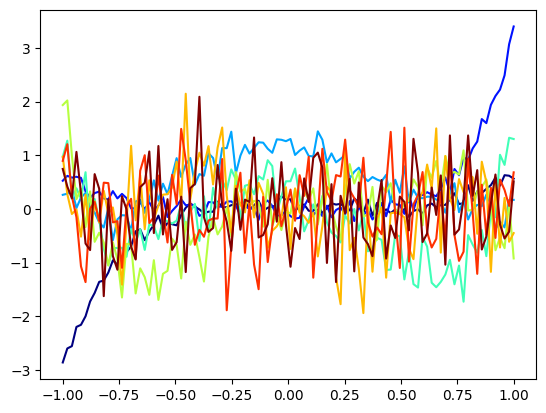

In [584]:
# Теперь мы выполняем одномерный FPCA, используя разложение оператора ковариации
# с точным числом компонент
ufpca_cov_p_comp = UFPCA(n_components=polynom_power, method="covariance")
ufpca_cov_p_comp.fit(data)

# Строим график собственных функций, используя полученное выше разложение
_ = plot(ufpca_cov_p_comp.eigenfunctions)
plt.show()

In [585]:
# Считаем оценки нашего разложения с помощью метода PACE,
# который мы описывали в лит. обзоре
scores_pace_p_comp = ufpca_cov_p_comp.transform(data, method="PACE")

### Наблюдения

В случае, когда шума в данных много, даже точное число компонент не обеспечивает хорошего восстановления наблюдений. Форма функций передана достаточно хорошо, однако, огромное число шума искажает наблюдаемую картину, что видно из графиков ниже.

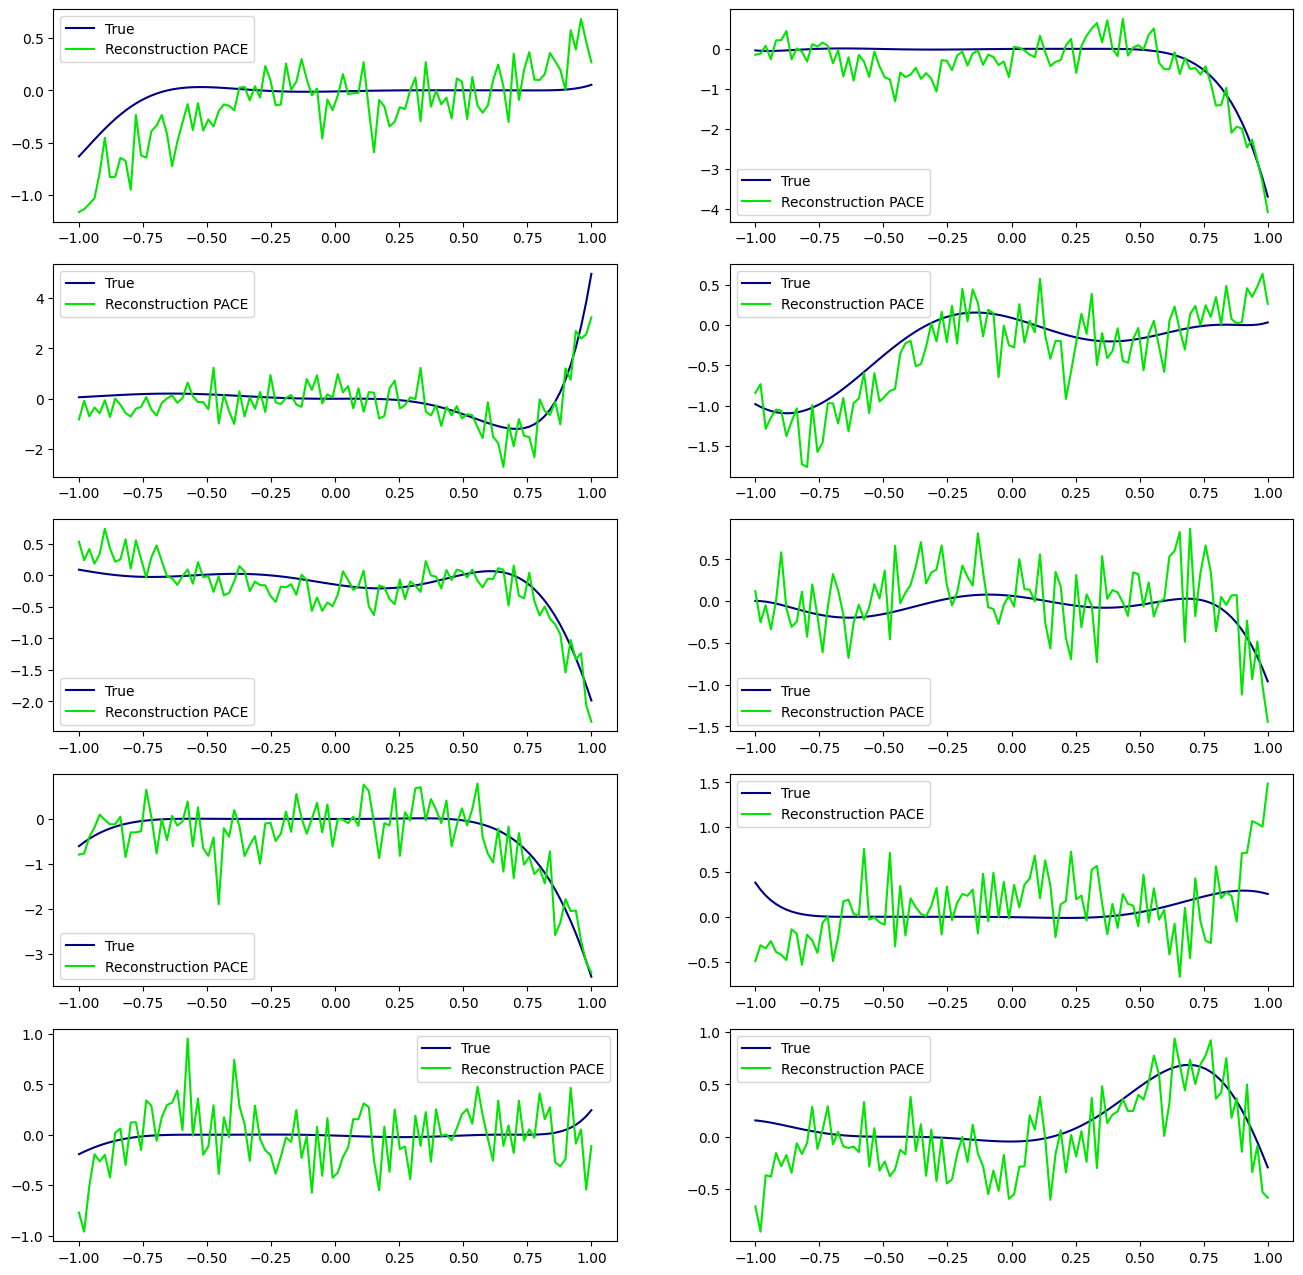

In [586]:
# Выполняем обратно преобразование очков в данные из
# уже имеющегося разложения
data_recons_pace = ufpca_cov_p_comp.inverse_transform(scores_pace_p_comp)

# Выбираем цвет, которым покрасим график восстановленных функций
colors_pace = np.array([[0, 0.9, 0, 1]])

np.random.seed(3)

# Строим сетку графиков и визуализируем 10 случайных наблюдений
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(16, 16))
for idx_plot, idx in enumerate(np.random.choice(function_count, 10)):
    temp_ax = axes.flatten()[idx_plot]
    # Визуализируем истинные, не зашумлённые наблюдения
    temp_ax = plot(data_true[idx], ax=temp_ax, label="True")
    # Визуализируем восстановленные из PACE очков функции
    plot(
        data_recons_pace[idx],
        colors=colors_pace,
        ax=temp_ax,
        label="Reconstruction PACE",
    )
    temp_ax.legend()
plt.show()

## Разложение с учётом объяснённой дисперсии

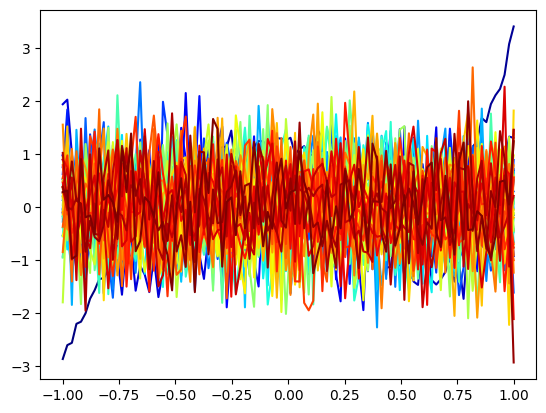

In [587]:
# Теперь мы выполняем одномерный FPCA, используя разложение оператора ковариации
# с адаптивным числом компонент, которое объясняет 99% дисперсии
ufpca_cov_a_comp = UFPCA(n_components=0.99, method="covariance")
ufpca_cov_a_comp.fit(data)

# Строим график собственных функций, используя полученное выше разложение
_ = plot(ufpca_cov_a_comp.eigenfunctions)
plt.show()

Адаптивный выбор числа компонент предлагает 51 функцию в базисе. Это крайне далеко от реального числа 8

In [588]:
ufpca_cov_a_comp.eigenfunctions

Functional data object with 51 observations on a 1-dimensional support.

In [589]:
# Считаем оценки нашего разложения с помощью метода PACE,
# который мы описывали в лит. обзоре
scores_pace_a_comp = ufpca_cov_a_comp.transform(data, method="PACE")

### Наблюдения

В случае, когда шума в данных много, адаптивный выбор числа компонент не справляется с определением реальной степени полиномов. Шум искажает реальную картину, создавая необъяснённую, но бессмысленную дисперсию, из-за чего и получилась 51 функция. Из графиков ниже видно, что ситуация не улучшилась по сравнению с точным числом компонент.

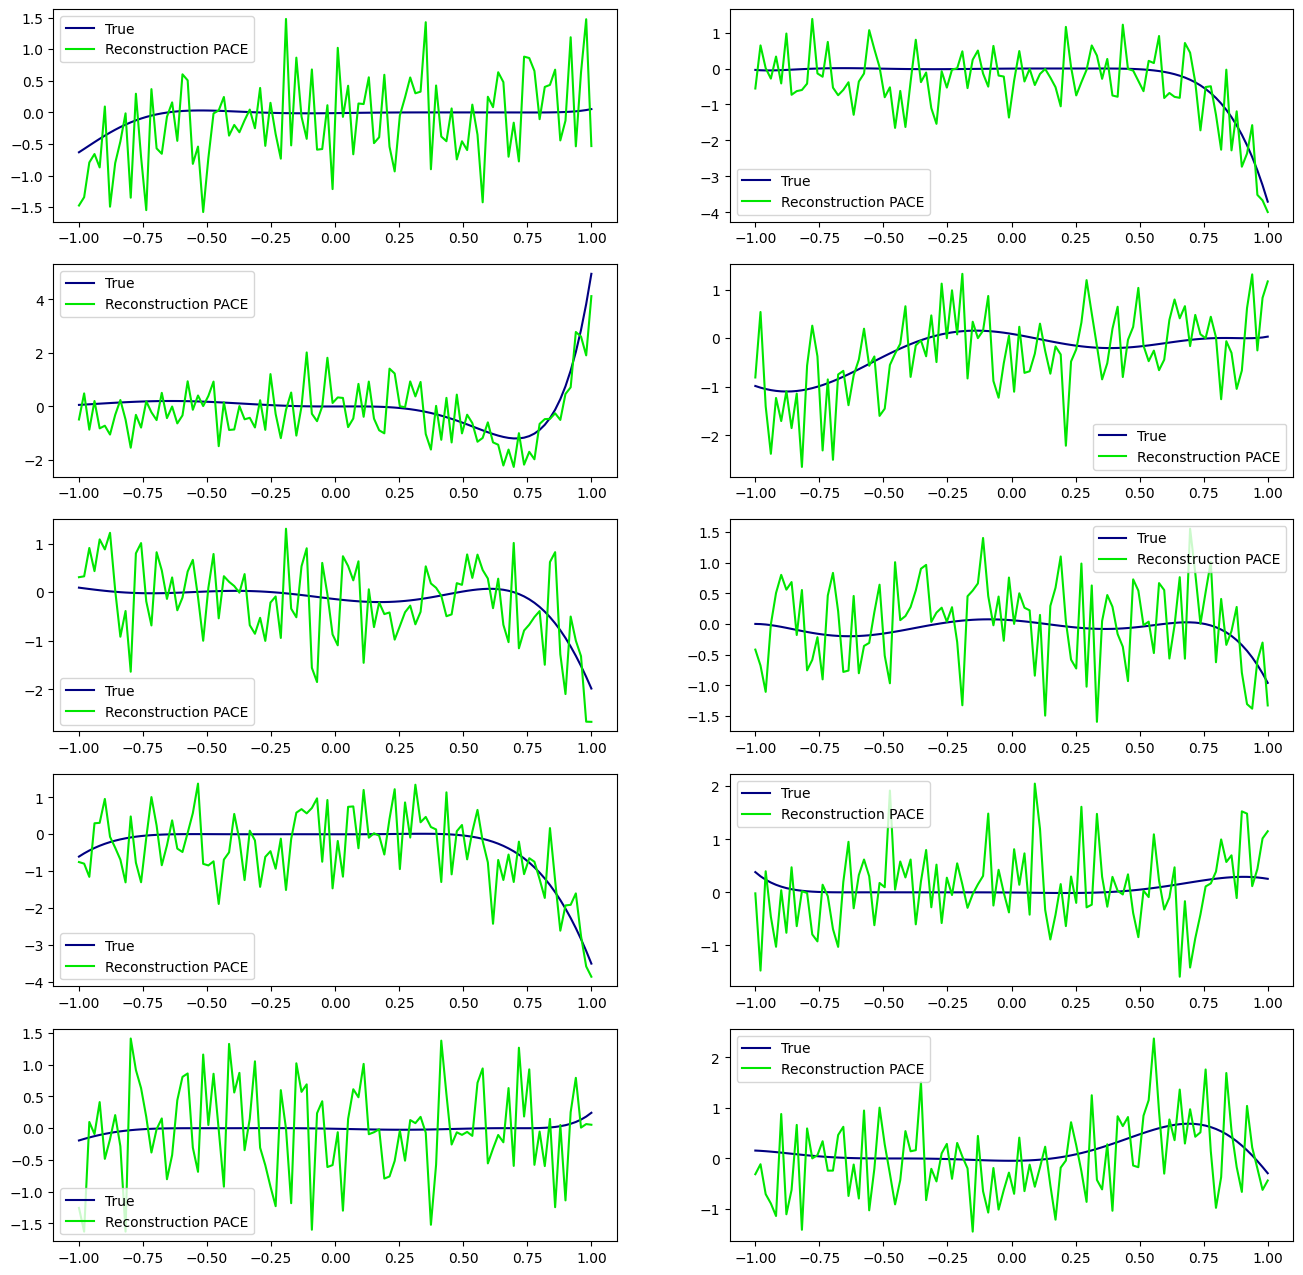

In [590]:
# Выполняем обратно преобразование очков в данные из
# уже имеющегося разложения
data_recons_pace = ufpca_cov_a_comp.inverse_transform(scores_pace_a_comp)

# Выбираем цвет, которым покрасим график восстановленных функций
colors_pace = np.array([[0, 0.9, 0, 1]])

np.random.seed(3)

# Строим сетку графиков и визуализируем 10 случайных наблюдений
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(16, 16))
for idx_plot, idx in enumerate(np.random.choice(function_count, 10)):
    temp_ax = axes.flatten()[idx_plot]
    # Визуализируем истинные, не зашумлённые наблюдения
    temp_ax = plot(data_true[idx], ax=temp_ax, label="True")
    # Визуализируем восстановленные из PACE очков функции
    plot(
        data_recons_pace[idx],
        colors=colors_pace,
        ax=temp_ax,
        label="Reconstruction PACE",
    )
    temp_ax.legend()
plt.show()

# Выводы

На основании проведённого анализа можно сделать следующие выводы:

1) FPCA с адаптивным выбором числа компонент не всегда определяет реальную степень полинома, т.к. компоненты полинома могут доминироваться более высокими порядками и не создавать должной дисперсии в данных,

2) Все методы одинаково плохо справляются с задачей, в которой шум забивает основной сигнал, рискуя промахнуться с числом компонент в более чем 6 раз, пытаясь объяснить шумовую дисперсию,

3) Для корректно поставленной задачи, где компоненты оказывают влияние на сигнал и шум не доминирует над ним, адаптивный выбор числа компонент находит окрестность реальной степени полинома.